In [1]:
#Importing all the necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import random
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image, ImageChops, ImageEnhance
from IPython.display import display # to display images


In [ ]:
#https://gist.github.com/cirocosta/33c758ad77e6e6531392
#error level analysis of an image
def ELA(img_path):
    """Performs Error Level Analysis over a directory of images"""
    
    TEMP = 'ela_' + 'temp.jpg'
    SCALE = 10
    original = Image.open(img_path)
    try:
        original.save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original, temporary)
        
    except:
        
        original.convert('RGB').save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original.convert('RGB'), temporary)
        
       
    d = diff.load()
    
    WIDTH, HEIGHT = diff.size
    for x in range(WIDTH):
        for y in range(HEIGHT):
            print(d[x,y])
            d[x, y] = tuple(k * SCALE for k in d[x, y])

    return diff


### Original image

In [ ]:
orig_img = Image.open('C:/Users/lukma/Desktop/temp/Beijing_style/10454_22959.png')
display(orig_img)

In [ ]:
ELA('C:/Users/lukma/Desktop/temp/Beijing_style/10454_22959.png')

### Tampered Image

In [ ]:
tampered_img = Image.open('casia_dataset/Tp/Tp_D_CND_S_N_ani00073_ani00068_00193.tif')
display(tampered_img)

In [ ]:
ELA('casia_dataset/Tp/Tp_D_CND_S_N_ani00073_ani00068_00193.tif')

* we can infer that When an image is altered, the compression ratio of the specific portion changes with respect to other parts.


### Few tampered images from the dataset

* Let's perform ELA on tampered images which are not so obvious to the human eye.

In [ ]:
#tampered image
Image.open('casia_dataset/Tp/Tp_D_CRN_M_N_nat10131_nat10124_11906.jpg')

In [ ]:
ELA('casia_dataset/Tp/Tp_D_CRN_M_N_nat10131_nat10124_11906.jpg')

In [ ]:
Image.open('casia_dataset/Tp/Tp_D_CRN_S_N_cha00063_art00014_11818.jpg')

In [ ]:
ELA('casia_dataset/Tp/Tp_D_CRN_S_N_cha00063_art00014_11818.jpg')

* Looks like the ribbon on her head is tampered.

In [ ]:
Image.open('casia_dataset/Tp/Tp_D_CRN_S_N_cha10122_nat10123_12168.jpg')

In [ ]:
ELA('casia_dataset/Tp/Tp_D_CRN_S_N_cha10122_nat10123_12168.jpg')

### Preparing the dataset

In [ ]:
#Let's prepare the dataset 

* 1)Each picture as the input data is first converted first into image Error Level Analysis.Then,the ELA image will be resized to size 128 x 128.
* 2) Next we normalize by dividing each RGB value with the number 255.0 to do normalization, so that CNN converges faster.

In [2]:
base_path = 'C:/Users/lukma/Desktop/resized_MAX_img/CEDAR'

In [3]:
images = []
for direc in os.listdir(base_path):
    it = 0
    for file in os.listdir(base_path+'/'+direc):
        line = base_path+'/'+direc + '/' +file  + ',{}\n'.format(direc)
        images.append(line)
        it+=1
        if (it > 19): break

In [4]:
print(images)

['C:/Users/lukma/Desktop/resized_MAX_img/CEDAR/1/original_1_1.png,1\n', 'C:/Users/lukma/Desktop/resized_MAX_img/CEDAR/1/original_1_10.png,1\n', 'C:/Users/lukma/Desktop/resized_MAX_img/CEDAR/1/original_1_11.png,1\n', 'C:/Users/lukma/Desktop/resized_MAX_img/CEDAR/1/original_1_12.png,1\n', 'C:/Users/lukma/Desktop/resized_MAX_img/CEDAR/1/original_1_13.png,1\n', 'C:/Users/lukma/Desktop/resized_MAX_img/CEDAR/1/original_1_14.png,1\n', 'C:/Users/lukma/Desktop/resized_MAX_img/CEDAR/1/original_1_15.png,1\n', 'C:/Users/lukma/Desktop/resized_MAX_img/CEDAR/1/original_1_16.png,1\n', 'C:/Users/lukma/Desktop/resized_MAX_img/CEDAR/1/original_1_17.png,1\n', 'C:/Users/lukma/Desktop/resized_MAX_img/CEDAR/1/original_1_18.png,1\n', 'C:/Users/lukma/Desktop/resized_MAX_img/CEDAR/1/original_1_19.png,1\n', 'C:/Users/lukma/Desktop/resized_MAX_img/CEDAR/1/original_1_2.png,1\n', 'C:/Users/lukma/Desktop/resized_MAX_img/CEDAR/1/original_1_20.png,1\n', 'C:/Users/lukma/Desktop/resized_MAX_img/CEDAR/1/original_1_21.png

In [5]:
image_name = []
label = []
for i in tqdm(range(len(images))):
    if (images[i][-3] == ','):
        image_name.append(images[i][0:-3])
        label.append(images[i][-2])
    else:
        image_name.append(images[i][0:-4])
        label.append(images[i][-3:-1])

100%|█████████████████████████████████████████████████████████████████████████| 1100/1100 [00:00<00:00, 1103236.35it/s]


In [6]:
dataset = pd.DataFrame({'image':image_name,'class_label':label})

In [7]:
dataset['class_label'].value_counts()

38    20
20    20
33    20
35    20
13    20
27    20
17    20
31    20
2     20
4     20
24    20
41    20
10    20
16    20
52    20
22    20
55    20
46    20
11    20
8     20
47    20
45    20
42    20
53    20
36    20
21    20
29    20
23    20
1     20
40    20
25    20
28    20
3     20
37    20
43    20
7     20
26    20
30    20
14    20
19    20
34    20
6     20
54    20
18    20
48    20
50    20
32    20
9     20
44    20
12    20
15    20
49    20
39    20
51    20
5     20
Name: class_label, dtype: int64

In [8]:
dataset.to_csv('gleban_cedar.csv',index=False)

In [103]:
x = []
y = []

In [104]:
import cv2
for index, row in tqdm(dataset.iterrows()):
    img = cv2.imread(row[0])
    x.append(np.array(img, dtype = float))
    y.append(row[1])

1100it [00:05, 213.73it/s]


In [89]:
img = cv2.imread('C:/Users/lukma/Desktop/resized_MAX_img/CEDAR/1/original_1_1.png')

In [108]:
y.shape

(1100, 56)

In [106]:
x = np.array(x)
y = np.array(y)
y = to_categorical(y)

In [114]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='tanh', input_shape = (127, 531, 3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='tanh'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = "tanh"))
model.add(Dropout(0.5))
model.add(Dense(56, activation = "softmax"))

In [115]:
optimizer = Adam()

In [116]:
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=["accuracy"])

In [117]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 123, 527, 32)      2432      
                                                                 
 conv2d_13 (Conv2D)          (None, 119, 523, 32)      25632     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 59, 261, 32)      0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 59, 261, 32)       0         
                                                                 
 flatten_6 (Flatten)         (None, 492768)            0         
                                                                 
 dense_12 (Dense)            (None, 256)               126148864 
                                                      

In [ ]:
history = model.fit(x, y, batch_size = 10, epochs = 5, verbose = 1)

In [ ]:
path_original = 'C:/Users/lukma/Desktop/temp/Tacoma/'
path_tampered = 'C:/Users/lukma/Desktop/temp/Beijing_style/'

total_original = os.listdir(path_original)
total_tampered = os.listdir(path_tampered)

In [ ]:
images = []
r = 0
for file in tqdm(os.listdir(path_original)):
    try:
        if file.endswith('jpg'):
            line = path_original + file  + ',0\n'
            images.append(line)
            r+=1
            if (r > 3000): break
    except:
        print(path_original+file)



In [ ]:
k = 0
for file in tqdm(os.listdir(path_tampered)):
    try:
        if file.endswith('jpg'):
                line = path_tampered + file + ',1\n'
                images.append(line)
                k+=1
                if (k > 3000): break
    except:
          print(path_tampered+file)



In [ ]:
image_name = []
label = []
for i in tqdm(range(len(images))):
    image_name.append(images[i][0:-3])
    label.append(images[i][-2])
    

In [ ]:
dataset = pd.DataFrame({'image':image_name,'class_label':label})

In [ ]:
dataset['class_label'].value_counts()


### Class labels

It is important to note that:
* class label 1 ===>tampered
* class label 0====>real

In [28]:
dataset.head()

,image,class_label
0,C:/Users/lukma/Desktop/DS/Povetry/train/real_j...,0
1,C:/Users/lukma/Desktop/DS/Povetry/train/real_j...,0
2,C:/Users/lukma/Desktop/DS/Povetry/train/real_j...,0
3,C:/Users/lukma/Desktop/DS/Povetry/train/real_j...,0
4,C:/Users/lukma/Desktop/DS/Povetry/train/real_j...,0


In [ ]:
dataset.to_csv('final_model_Povetry.csv',index=False)

In [23]:
dataset = pd.read_csv('final_model_Povetry.csv')

In [24]:
len(dataset)

6000

In [ ]:
x_pov = []
y_pov = []

In [ ]:
for index, row in tqdm(dataset.iterrows()):
    x_pov.append(np.array(ELA(row[0])).resize((128, 128))).flatten() / 255.0)
    y_pov.append(row[1])

In [ ]:
#converting X and Y to numpy arrays
x_pov = np.array(x_pov)
y_pov = np.array(y_pov)


### Reshape X

In [ ]:
x_pov = x_pov.reshape(-1, 128, 128, 3)

In [ ]:
x_pov[0]

In [ ]:
y_pov = to_categorical(y_pov, 2) #y is one hot encoded

In [ ]:
y_pov[0] 

In [ ]:
len(x_pov)

In [ ]:
from numpy import save
## save all the data 
save('X_train.npy', x_casia)
save('Y_train.npy',y_casia)

In [57]:
from numpy import load

In [58]:
x_t = load('np_bst/X_final_train_BST.npy')
y_t = load('np_bst/Y_final_train_BST.npy')
x_v = load('np_bst/X_final_valid_BST.npy')
y_v = load('np_bst/Y_final_valid_BST.npy')


In [59]:
x_t.shape

(6048, 128, 128, 3)

In [5]:
x_con = np.concatenate((x_t, x_v), axis = 0)

In [6]:
y_con = np.concatenate((y_t, y_v), axis = 0)

In [7]:
x_pt = load('np_pov/X_final_train_Povetry.npy')  
x_pv = load('np_pov/X_final_valid_Povetry.npy')
y_pt = load('np_pov/Y_final_train_Povetry.npy')
y_pv = load('np_pov/Y_final_valid_Povetry.npy')

In [8]:
x_con_p = np.concatenate((x_pt, x_pv), axis = 0)
y_con_p = np.concatenate((y_pt, y_pv), axis = 0)

In [9]:
x_con_sum = np.concatenate((x_con, x_con_p), axis = 0)
y_con_sum = np.concatenate((y_con, y_con_p), axis = 0)

In [10]:
Xb_test = load('np_bst/X_final_test_BST.npy')
Yb_test = load('np_bst/Y_final_test_BST.npy')

In [11]:
Xp_test = load('np_pov/X_final_test_Povetry.npy')
Yp_test = load('np_pov/Y_final_test_Povetry.npy')

In [12]:
Xs_test = np.concatenate((Xb_test, Xp_test), axis = 0)
Ys_test = np.concatenate((Yb_test, Yp_test), axis = 0)

### Train-test split

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
Xb_train, Xb_val, Yb_train, Yb_val = train_test_split(x_con, y_con, test_size = 0.14, random_state=5)

In [15]:
Xp_train, Xp_val, Yp_train, Yp_val = train_test_split(x_con_p, y_con_p, test_size = 0.14, random_state=7)

In [16]:
Xs_train, Xs_val, Ys_train, Ys_val = train_test_split(x_con_sum, y_con_sum, test_size = 0.14, random_state=5)

In [15]:
from numpy import save
## save sum data 
save('X_final_train_sum.npy', Xs_train)
save('Y_final_train_sum.npy',Ys_train)
save('X_final_valid_sum.npy', Xs_val)
save('Y_final_valid_sum.npy',Ys_val)
save('X_final_test_sum.npy', Xs_test)
save('Y_final_test_sum.npy',Ys_test)


In [ ]:
from numpy import load



In [21]:
###model cnn

In [24]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu', input_shape = (128,128,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

In [25]:
optimizer = Adam()

In [26]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense_1 (Dense)             (None, 256)               29491456  
                                                      

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [9]:
def build_model(pretrained):
    model = Sequential([
        pretrained,
        layers.GlobalAveragePooling2D(),
        layers.Dense(2, activation='sigmoid')
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy']
    )
    
    return model

In [10]:
densenet = DenseNet121(
    weights=None,
    include_top=False,
    input_shape=(128,128,3)
)
model = build_model(densenet)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 2050      
                                                                 
Total params: 7,039,554
Trainable params: 6,955,906
Non-trainable params: 83,648
_________________________________________________________________


In [12]:
#for i in range (30):
history = model.fit(Xb_train, Yb_train, batch_size = 100, epochs = 30, 
    validation_data = (Xb_val, Yb_val), verbose = 1)
model.save('densenet_model_BST.h5')

Epoch 1/30
61/61 [==============================] - 719s 12s/step - loss: 0.3803 - accuracy: 0.8116 - val_loss: 7.2339 - val_accuracy: 0.5111
Epoch 2/30
61/61 [==============================] - 698s 11s/step - loss: 0.2722 - accuracy: 0.8744 - val_loss: 14.8460 - val_accuracy: 0.5111
Epoch 3/30
61/61 [==============================] - 701s 11s/step - loss: 0.2319 - accuracy: 0.8975 - val_loss: 7.7350 - val_accuracy: 0.5111
Epoch 4/30
61/61 [==============================] - 693s 11s/step - loss: 0.2276 - accuracy: 0.9049 - val_loss: 8.3034 - val_accuracy: 0.5111
Epoch 5/30
61/61 [==============================] - 695s 11s/step - loss: 0.1865 - accuracy: 0.9197 - val_loss: 14.3725 - val_accuracy: 0.5111
Epoch 6/30
61/61 [==============================] - 697s 11s/step - loss: 0.2006 - accuracy: 0.9164 - val_loss: 0.7771 - val_accuracy: 0.5111
Epoch 7/30
61/61 [==============================] - 697s 11s/step - loss: 0.1860 - accuracy: 0.9237 - val_loss: 2.9443 - val_accuracy: 0.5111
Epoc

In [14]:
model.save('densenet_model_Povetry.h5')

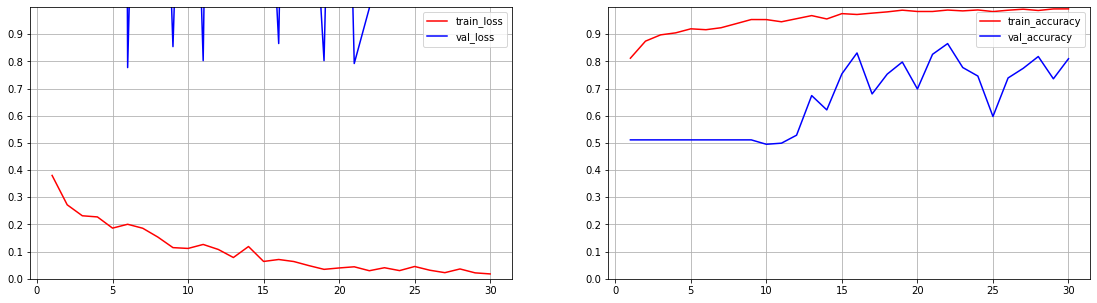

In [13]:
fig = plt.figure(figsize = (19, 5))
p1 = fig.add_subplot(121)
p2 = fig.add_subplot(122)
p1.set_ylim(0,1)
p2.set_ylim(0,1)
p1.grid()
p2.grid()
#p3.grid()
#p4.grid()
p1.set_yticks(np.arange(0,1,0.1))
p2.set_yticks(np.arange(0,1,0.1))
x = [i for i in range(1, 31)]
y = history.history['loss']
y2 = history.history['accuracy']
y3 = history.history['val_loss']
y4 = history.history['val_accuracy']
p1.plot(x,y, 'r', label='train_loss')

p2.plot(x,y2, 'r', label='train_accuracy')

p1.plot(x,y3, 'b', label='val_loss')

p2.plot(x,y4, 'b', label='val_accuracy')

p1.legend()
p2.legend()
plt.show()

# DenseNet + Povetry

In [13]:
from keras.models import load_model
from sklearn import metrics
import numpy as np
from tqdm import tqdm

arr_y_densenet_pov = np.zeros(30)
arr_y_densenet_pov1 = np.zeros(30)
arr_y_densenet_pov2 = np.zeros(30)
arr_y_densenet_pov3 = np.zeros(30)

for i in tqdm(range(30)):
    loaded_model_densenet_pov = load_model('densenet_pov_models/densenet_model_{}epoch.h5'.format(i+1))
    
    y_pred_densenet_pov = loaded_model_densenet_pov.predict(Xp_val)
    y_pred_densenet_pov = np.argmax(y_pred_densenet_pov,axis = 1)
    
    y_pred_densenet_pov1 = loaded_model_densenet_pov.predict(Xp_train)
    y_pred_densenet_pov1 = np.argmax(y_pred_densenet_pov1,axis = 1)
    
    y_pred_densenet_pov2 = loaded_model_densenet_pov.predict(Xp_test)
    y_pred_densenet_pov2 = np.argmax(y_pred_densenet_pov2,axis = 1)
    
    y_pred_densenet_pov3 = loaded_model_densenet_pov.predict(Xb_test)
    y_pred_densenet_pov3 = np.argmax(y_pred_densenet_pov3,axis = 1)
    
    # Convert validation observations to one hot vectors
    Y_true_densenet_pov = np.argmax(Yp_val,axis = 1) 
    Y_true_densenet_pov1 = np.argmax(Yp_train,axis = 1)
    Y_true_densenet_pov2 = np.argmax(Yp_test,axis = 1)
    Y_true_densenet_pov3 = np.argmax(Yb_test,axis = 1)
    
    score = metrics.accuracy_score(Y_true_densenet_pov, y_pred_densenet_pov)
    score1 = metrics.accuracy_score(Y_true_densenet_pov1, y_pred_densenet_pov1)
    score2 = metrics.accuracy_score(Y_true_densenet_pov2, y_pred_densenet_pov2)
    score3 = metrics.accuracy_score(Y_true_densenet_pov3, y_pred_densenet_pov3)
    
    arr_y_densenet_pov[i] += score
    arr_y_densenet_pov1[i] += score1
    arr_y_densenet_pov2[i] += score2
    arr_y_densenet_pov3[i] += score3

100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [1:25:08<00:00, 170.27s/it]


In [15]:
arr_y_densenet_pov1

array([0.50556571, 0.49443429, 0.50556571, 0.49443429, 0.49443429,
       0.49443429, 0.49443429, 0.49443429, 0.49443429, 0.49443429,
       0.49443429, 0.49443429, 0.49443429, 0.62452235, 0.51952152,
       0.73816249, 0.57418176, 0.62419006, 0.5436119 , 0.8258847 ,
       0.51486958, 0.65442765, 0.84748297, 0.93653431, 0.94201695,
       0.60242565, 0.80628011, 0.85828211, 0.58531317, 0.70526666])

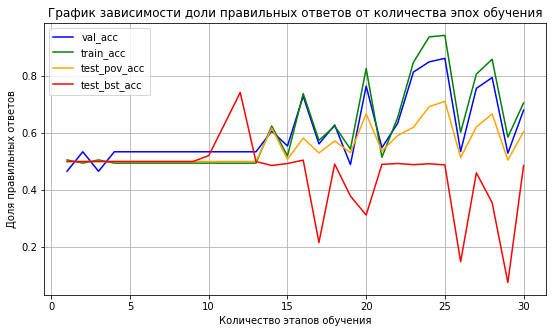

In [14]:
import matplotlib.pyplot as plt

x_densenet_pov_os = [i for i in range(1, 31)]
y_densenet_pov_os = arr_y_densenet_pov
y_densenet_pov_os1 = arr_y_densenet_pov1
y_densenet_pov_os2 = arr_y_densenet_pov2
y_densenet_pov_os3 = arr_y_densenet_pov3

fig, ax = plt.subplots(figsize = (9, 5))
plt.xlabel("Количество этапов обучения")         
plt.ylabel("Доля правильных ответов")
line1 = ax.plot(x_densenet_pov_os, y_densenet_pov_os, 'b', label = 'val_acc' )
line2 = ax.plot(x_densenet_pov_os, y_densenet_pov_os1, 'green', label = 'train_acc')
line3 = ax.plot(x_densenet_pov_os, y_densenet_pov_os2, 'orange', label = 'test_pov_acc')
line4 = ax.plot(x_densenet_pov_os, y_densenet_pov_os3, 'red', label = 'test_bst_acc' )

ax.set_title('График зависимости доли правильных ответов от количества эпох обучения')
ax.legend()
ax.grid(True)
plt.savefig("accuracy densenet Povetry.png")

In [25]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
loaded_model_densenet_pov = load_model('densenet_pov_models/densenet_model_25epoch.h5')
y_pred_densenet_pov = loaded_model_densenet_pov.predict(Xp_val)
y_pred_densenet_pov = np.argmax(y_pred_densenet_pov,axis = 1)
# Convert validation observations to one hot vectors
Y_true_densenet_pov = np.argmax(Yp_val,axis = 1) 

score = metrics.accuracy_score(Y_true_densenet_pov,y_pred_densenet_pov)
print("Accuracy score: {}".format(score))
score = metrics.precision_score(Y_true_densenet_pov,y_pred_densenet_pov, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(Y_true_densenet_pov,y_pred_densenet_pov, average= "weighted")
print("Recall score: {}".format(score))
score_lr1 = metrics.f1_score(Y_true_densenet_pov,y_pred_densenet_pov, average= "weighted")
print("F1 score: {}".format(score_lr1))

Accuracy score: 0.8613659531090724
Precision score: 0.861410752919397
Recall score: 0.8613659531090724
F1 score: 0.8613847629921118


Confusion matrix:
 [[455  69]
 [ 67 390]]
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       524
           1       0.85      0.85      0.85       457

    accuracy                           0.86       981
   macro avg       0.86      0.86      0.86       981
weighted avg       0.86      0.86      0.86       981

Plot of Confusion Matrix


<AxesSubplot:xlabel='Actual', ylabel='Predicted'>

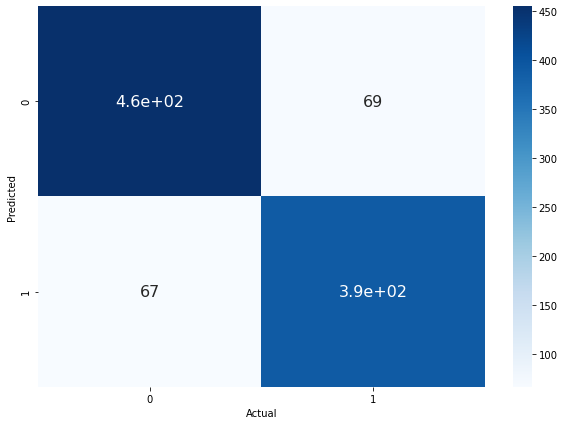

In [26]:
import seaborn as sns
cm_densenet_pov = confusion_matrix(Y_true_densenet_pov,y_pred_densenet_pov)
print('Confusion matrix:\n',cm_densenet_pov)

print(classification_report(Y_true_densenet_pov,y_pred_densenet_pov))

print('Plot of Confusion Matrix')
df_cm_densenet_pov = pd.DataFrame(cm_densenet_pov, columns=np.unique(Y_true_densenet_pov), index = np.unique(Y_true_densenet_pov))
df_cm_densenet_pov.index.name = 'Predicted'
df_cm_densenet_pov.columns.name = 'Actual'
plt.figure(figsize = (10,7))
#sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm_densenet_pov, cmap="Blues", annot=True, annot_kws={"size": 16})# font size

In [27]:
from sklearn.metrics import roc_auc_score
print('ROC_AUC score:',roc_auc_score(Y_true_densenet_pov,y_pred_densenet_pov))
df_cm_densenet_pov

ROC_AUC score: 0.8608561477942773


Actual,0,1
Predicted,,
0,455,69
1,67,390


Confusion matrix, without normalization
[[455  69]
 [ 67 390]]


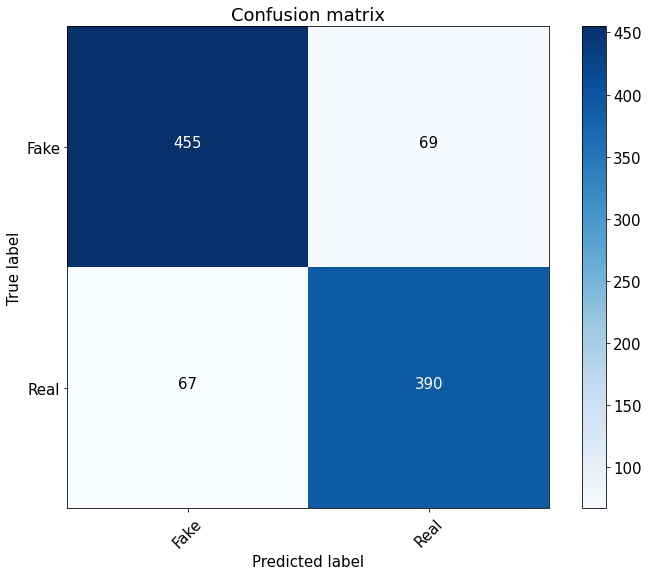

In [41]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_svm = confusion_matrix(Y_true_densenet_pov, y_pred_densenet_pov)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_svm, classes=['Fake', 'Real'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_densenet_pov.png")
plt.show()

# DenseNet + BST

In [20]:
from keras.models import load_model
from sklearn import metrics
import numpy as np
from tqdm import tqdm

arr_y_densenet_bst = np.zeros(30)
arr_y_densenet_bst1 = np.zeros(30)
arr_y_densenet_bst2 = np.zeros(30)
arr_y_densenet_bst3 = np.zeros(30)

for i in tqdm(range(30)):
    loaded_model_densenet_bst = load_model('densenet_bst_models/densenet_model_{}epoch_BST.h5'.format(i+1))
    
    y_pred_densenet_bst = loaded_model_densenet_bst.predict(Xb_val)
    y_pred_densenet_bst = np.argmax(y_pred_densenet_bst,axis = 1)
    
    y_pred_densenet_bst1 = loaded_model_densenet_bst.predict(Xb_train)
    y_pred_densenet_bst1 = np.argmax(y_pred_densenet_bst1,axis = 1)
    
    y_pred_densenet_bst2 = loaded_model_densenet_bst.predict(Xp_test)
    y_pred_densenet_bst2 = np.argmax(y_pred_densenet_bst2,axis = 1)
    
    y_pred_densenet_bst3 = loaded_model_densenet_bst.predict(Xb_test)
    y_pred_densenet_bst3 = np.argmax(y_pred_densenet_bst3,axis = 1)
    
    # Convert validation observations to one hot vectors
    Y_true_densenet_bst = np.argmax(Yb_val,axis = 1) 
    Y_true_densenet_bst1 = np.argmax(Yb_train,axis = 1)
    Y_true_densenet_bst2 = np.argmax(Yp_test,axis = 1)
    Y_true_densenet_bst3 = np.argmax(Yb_test,axis = 1)
    
    score = metrics.accuracy_score(Y_true_densenet_bst, y_pred_densenet_bst)
    score1 = metrics.accuracy_score(Y_true_densenet_bst1, y_pred_densenet_bst1)
    score2 = metrics.accuracy_score(Y_true_densenet_bst2, y_pred_densenet_bst2)
    score3 = metrics.accuracy_score(Y_true_densenet_bst3, y_pred_densenet_bst3)
    
    arr_y_densenet_bst[i] += score
    arr_y_densenet_bst1[i] += score1
    arr_y_densenet_bst2[i] += score2
    arr_y_densenet_bst3[i] += score3

100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [1:31:51<00:00, 183.72s/it]


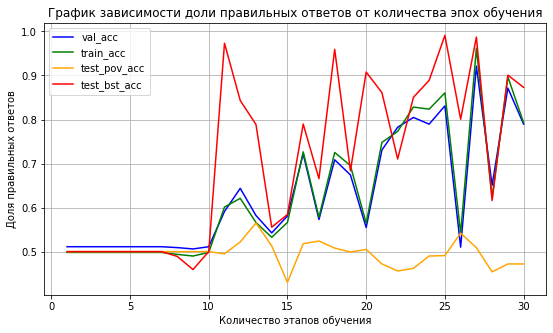

In [21]:
import matplotlib.pyplot as plt

x_densenet_bst_os = [i for i in range(1, 31)]
y_densenet_bst_os = arr_y_densenet_bst
y_densenet_bst_os1 = arr_y_densenet_bst1
y_densenet_bst_os2 = arr_y_densenet_bst2
y_densenet_bst_os3 = arr_y_densenet_bst3

fig, ax = plt.subplots(figsize = (9, 5))
plt.xlabel("Количество этапов обучения")         
plt.ylabel("Доля правильных ответов")
line1 = ax.plot(x_densenet_bst_os, y_densenet_bst_os, 'b', label = 'val_acc' )
line2 = ax.plot(x_densenet_bst_os, y_densenet_bst_os1, 'green', label = 'train_acc')
line3 = ax.plot(x_densenet_bst_os, y_densenet_bst_os2, 'orange', label = 'test_pov_acc')
line4 = ax.plot(x_densenet_bst_os, y_densenet_bst_os3, 'red', label = 'test_bst_acc' )

ax.set_title('График зависимости доли правильных ответов от количества эпох обучения')
ax.legend()
ax.grid(True)
plt.savefig("accuracy densenet BST.png")

In [28]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
loaded_model_densenet_bst = load_model('densenet_bst_models/densenet_model_27epoch_BST.h5')
y_pred_densenet_bst = loaded_model_densenet_bst.predict(Xb_val)
y_pred_densenet_bst = np.argmax(y_pred_densenet_bst,axis = 1)
# Convert validation observations to one hot vectors
Y_true_densenet_bst = np.argmax(Yb_val,axis = 1) 

score = metrics.accuracy_score(Y_true_densenet_bst,y_pred_densenet_bst)
print("Accuracy score: {}".format(score))
score = metrics.precision_score(Y_true_densenet_bst,y_pred_densenet_bst, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(Y_true_densenet_bst,y_pred_densenet_bst, average= "weighted")
print("Recall score: {}".format(score))
score_lr1 = metrics.f1_score(Y_true_densenet_bst,y_pred_densenet_bst, average= "weighted")
print("F1 score: {}".format(score_lr1))

Accuracy score: 0.9210526315789473
Precision score: 0.9225066845627032
Recall score: 0.9210526315789473
F1 score: 0.9210390437813935


Confusion matrix:
 [[455  69]
 [ 67 390]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       483
           1       0.95      0.90      0.92       505

    accuracy                           0.92       988
   macro avg       0.92      0.92      0.92       988
weighted avg       0.92      0.92      0.92       988

Plot of Confusion Matrix


<AxesSubplot:xlabel='Actual', ylabel='Predicted'>

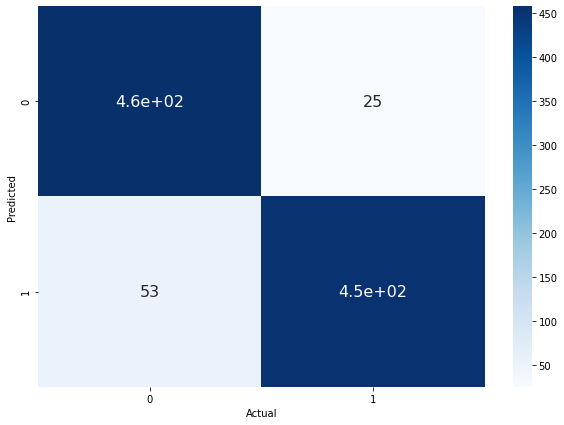

In [29]:
import seaborn as sns
cm_densenet_bst = confusion_matrix(Y_true_densenet_bst,y_pred_densenet_bst)
print('Confusion matrix:\n',cm_densenet_pov)

print(classification_report(Y_true_densenet_bst,y_pred_densenet_bst))

print('Plot of Confusion Matrix')
df_cm_densenet_bst = pd.DataFrame(cm_densenet_bst, columns=np.unique(Y_true_densenet_bst), index = np.unique(Y_true_densenet_bst))
df_cm_densenet_bst.index.name = 'Predicted'
df_cm_densenet_bst.columns.name = 'Actual'
plt.figure(figsize = (10,7))
#sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm_densenet_bst, cmap="Blues", annot=True, annot_kws={"size": 16})# font size

In [30]:
from sklearn.metrics import roc_auc_score
print('ROC_AUC score:',roc_auc_score(Y_true_densenet_bst,y_pred_densenet_bst))
df_cm_densenet_bst

ROC_AUC score: 0.9216448352909824


Actual,0,1
Predicted,,
0,458,25
1,53,452


Confusion matrix, without normalization
[[458  25]
 [ 53 452]]


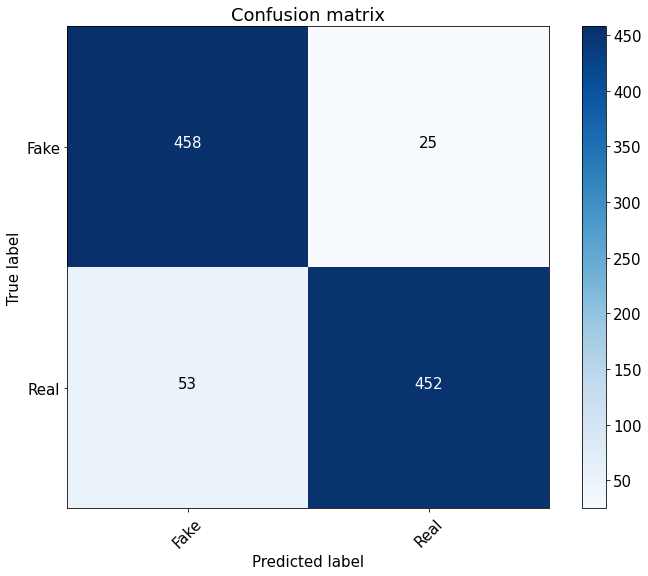

In [40]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_svm = confusion_matrix(Y_true_densenet_bst, y_pred_densenet_bst)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_svm, classes=['Fake', 'Real'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_densenet_bst.png")
plt.show()

# Стандартная CNN + Povetry

In [14]:
from keras.models import load_model
from sklearn import metrics
import numpy as np
from tqdm import tqdm

arr_cnn_pov_y = np.zeros(45)
arr_cnn_pov_y1 = np.zeros(45)
arr_cnn_pov_y2 = np.zeros(45)
arr_cnn_pov_y3 = np.zeros(45)
for i in tqdm(range(45)):
    loaded_model_cnn_pov = load_model('Pov_models/model_{}epoch_Povetry.h5'.format(i+1))
    
    y_pred_cnn_pov = loaded_model_cnn_pov.predict(Xp_val)
    y_pred_cnn_pov = np.argmax(y_pred_cnn_pov,axis = 1)
    
    y_pred_cnn_pov1 = loaded_model_cnn_pov.predict(Xp_train)
    y_pred_cnn_pov1 = np.argmax(y_pred_cnn_pov1,axis = 1)
    
    y_pred_cnn_pov2 = loaded_model_cnn_pov.predict(Xp_test)
    y_pred_cnn_pov2 = np.argmax(y_pred_cnn_pov2,axis = 1)
    
    y_pred_cnn_pov3 = loaded_model_cnn_pov.predict(Xb_test)
    y_pred_cnn_pov3 = np.argmax(y_pred_cnn_pov3,axis = 1)
    
    # Convert validation observations to one hot vectors
    Y_true_cnn_pov = np.argmax(Yp_val,axis = 1) 
    Y_true_cnn_pov1 = np.argmax(Yp_train,axis = 1)
    Y_true_cnn_pov2 = np.argmax(Yp_test,axis = 1)
    Y_true_cnn_pov3 = np.argmax(Yb_test,axis = 1)
    
    score = metrics.accuracy_score(Y_true_cnn_pov, y_pred_cnn_pov)
    score1 = metrics.accuracy_score(Y_true_cnn_pov1, y_pred_cnn_pov1)
    score2 = metrics.accuracy_score(Y_true_cnn_pov2, y_pred_cnn_pov2)
    score3 = metrics.accuracy_score(Y_true_cnn_pov3, y_pred_cnn_pov3)
    
    arr_cnn_pov_y[i] += score
    arr_cnn_pov_y1[i] += score1
    arr_cnn_pov_y2[i] += score2
    arr_cnn_pov_y3[i] += score3

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [38:55<00:00, 51.90s/it]


In [37]:
arr_cnn_pov_y

array([0.58103976, 0.53414883, 0.60754332, 0.62996942, 0.65647299,
       0.6911315 , 0.51987768, 0.64729867, 0.68705403, 0.72477064,
       0.73394495, 0.80020387, 0.80937819, 0.745158  , 0.87054027,
       0.88481142, 0.89908257, 0.90723751, 0.92456677, 0.93781855,
       0.91335372, 0.9459735 , 0.95005097, 0.94393476, 0.95616718,
       0.96228338, 0.95820591, 0.95820591, 0.95514781, 0.95922528,
       0.95922528, 0.96330275, 0.96636086, 0.96839959, 0.96839959,
       0.96738022, 0.96330275, 0.96738022, 0.96738022, 0.96432212,
       0.96534149, 0.96839959, 0.96636086, 0.96941896, 0.96941896])

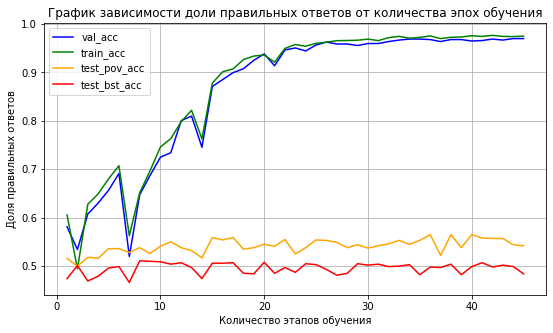

In [17]:
import matplotlib.pyplot as plt
xp_os = [i for i in range(1, len(arr_cnn_pov_y)+1)]
yp_os = arr_cnn_pov_y
yp_os1 = arr_cnn_pov_y1
yp_os2 = arr_cnn_pov_y2
yp_os3 = arr_cnn_pov_y3

fig, ax = plt.subplots(figsize = (9, 5))
plt.xlabel("Количество этапов обучения")         
plt.ylabel("Доля правильных ответов")

line1 = ax.plot(xp_os, yp_os, 'blue', label = 'val_acc')
line2 = ax.plot(xp_os, yp_os1, 'green', label = 'train_acc')
line3 = ax.plot(xp_os, yp_os2, 'orange', label = 'test_pov_acc')
line4 = ax.plot(xp_os, yp_os3, 'red', label = 'test_bst_acc')

ax.set_title('График зависимости доли правильных ответов от количества эпох обучения')
ax.legend()
ax.grid(True)
plt.savefig("accuracy CNN Povetry.png")

In [31]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import load_model
from sklearn import metrics
import numpy as np
from tqdm import tqdm
loaded_model_cnn_pov = load_model('Pov_models/model_45epoch_Povetry.h5')
y_pred_cnn_pov = loaded_model_cnn_pov.predict(Xp_val)
y_pred_cnn_pov = np.argmax(y_pred_cnn_pov,axis = 1)
# Convert validation observations to one hot vectors
Y_true_cnn_pov = np.argmax(Yp_val,axis = 1) 

score = metrics.accuracy_score(Y_true_cnn_pov, y_pred_cnn_pov)
print("Accuracy score: {}".format(score))
score = metrics.precision_score(Y_true_cnn_pov, y_pred_cnn_pov, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(Y_true_cnn_pov, y_pred_cnn_pov, average= "weighted")
print("Recall score: {}".format(score))
score_lr1 = metrics.f1_score(Y_true_cnn_pov, y_pred_cnn_pov, average= "weighted")
print("F1 score: {}".format(score_lr1))

Accuracy score: 0.9694189602446484
Precision score: 0.9695783273035384
Recall score: 0.9694189602446484
F1 score: 0.9694340134846413


Confusion matrix:
 [[505  19]
 [ 11 446]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       524
           1       0.96      0.98      0.97       457

    accuracy                           0.97       981
   macro avg       0.97      0.97      0.97       981
weighted avg       0.97      0.97      0.97       981

Plot of Confusion Matrix


<AxesSubplot:xlabel='Actual', ylabel='Predicted'>

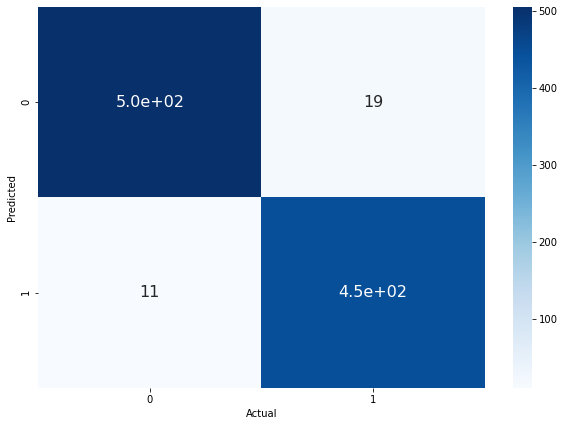

In [32]:
import seaborn as sns
cm_cnn_pov = confusion_matrix(Y_true_cnn_pov, y_pred_cnn_pov)
print('Confusion matrix:\n',cm_cnn_pov)

print(classification_report(Y_true_cnn_pov, y_pred_cnn_pov))

print('Plot of Confusion Matrix')
df_cm_cnn_pov = pd.DataFrame(cm_cnn_pov, columns=np.unique(Y_true_cnn_pov), index = np.unique(Y_true_cnn_pov))
df_cm_cnn_pov.index.name = 'Predicted'
df_cm_cnn_pov.columns.name = 'Actual'
plt.figure(figsize = (10,7))
#sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm_cnn_pov, cmap="Blues", annot=True, annot_kws={"size": 16})# font size

In [33]:
from sklearn.metrics import roc_auc_score
print('ROC_AUC score:',roc_auc_score(Y_true_cnn_pov, y_pred_cnn_pov))
df_cm_cnn_pov

ROC_AUC score: 0.9698352180667146


Actual,0,1
Predicted,,
0,505,19
1,11,446


Confusion matrix, without normalization
[[505  19]
 [ 11 446]]


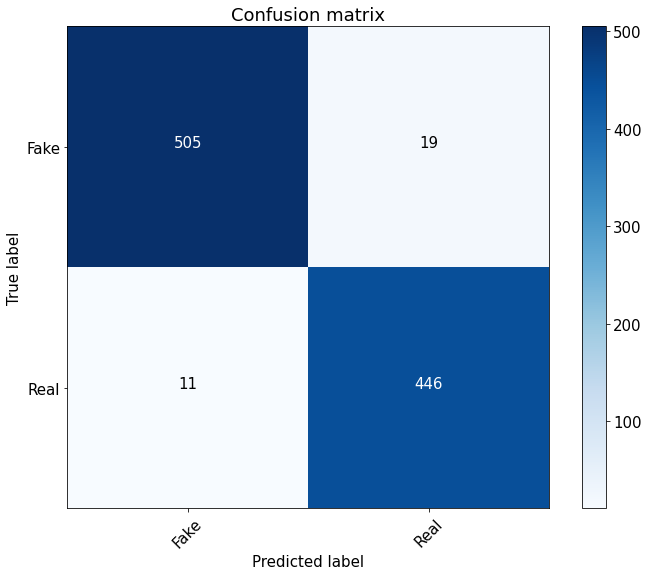

In [42]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_svm = confusion_matrix(Y_true_cnn_pov, y_pred_cnn_pov)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_svm, classes=['Fake', 'Real'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_cnn_pov.png")
plt.show()

# Стандартная CNN + BST

In [9]:
from keras.models import load_model
from sklearn import metrics
import numpy as np
from tqdm import tqdm

arr_cnn_bst_y = np.zeros(15)
arr_cnn_bst_y1 = np.zeros(15)
arr_cnn_bst_y2 = np.zeros(15)
arr_cnn_bst_y3 = np.zeros(15)
for i in tqdm(range(15)):
    loaded_model_cnn_bst = load_model('BST_models/model_{}epoch_BST.h5'.format(i+1))
    
    y_pred_cnn_bst = loaded_model_cnn_bst.predict(Xb_val)
    y_pred_cnn_bst = np.argmax(y_pred_cnn_bst,axis = 1)
    
    y_pred_cnn_bst1 = loaded_model_cnn_bst.predict(Xb_train)
    y_pred_cnn_bst1 = np.argmax(y_pred_cnn_bst1,axis = 1)
    
    y_pred_cnn_bst2 = loaded_model_cnn_bst.predict(Xp_test)
    y_pred_cnn_bst2 = np.argmax(y_pred_cnn_bst2,axis = 1)
    
    y_pred_cnn_bst3 = loaded_model_cnn_bst.predict(Xb_test)
    y_pred_cnn_bst3 = np.argmax(y_pred_cnn_bst3,axis = 1)
    
    # Convert validation observations to one hot vectors
    Y_true_cnn_bst = np.argmax(Yb_val,axis = 1) 
    Y_true_cnn_bst1 = np.argmax(Yb_train,axis = 1)
    Y_true_cnn_bst2 = np.argmax(Yp_test,axis = 1)
    Y_true_cnn_bst3 = np.argmax(Yb_test,axis = 1)
    
    score = metrics.accuracy_score(Y_true_cnn_bst, y_pred_cnn_bst)
    score1 = metrics.accuracy_score(Y_true_cnn_bst1, y_pred_cnn_bst1)
    score2 = metrics.accuracy_score(Y_true_cnn_bst2, y_pred_cnn_bst2)
    score3 = metrics.accuracy_score(Y_true_cnn_bst3, y_pred_cnn_bst3)
    
    arr_cnn_bst_y[i] += score
    arr_cnn_bst_y1[i] += score1
    arr_cnn_bst_y2[i] += score2
    arr_cnn_bst_y3[i] += score3

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [10:29<00:00, 41.94s/it]


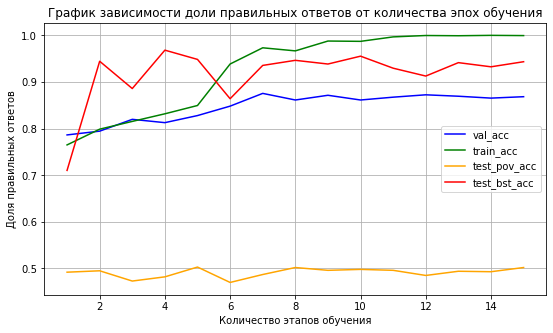

In [10]:
import matplotlib.pyplot as plt
x_cnn_bst_os = [i for i in range(1, len(arr_cnn_bst_y)+1)]
y_cnn_bst_os = arr_cnn_bst_y
y_cnn_bst_os1 = arr_cnn_bst_y1
y_cnn_bst_os2 = arr_cnn_bst_y2
y_cnn_bst_os3 = arr_cnn_bst_y3

fig, ax = plt.subplots(figsize = (9, 5))
plt.xlabel("Количество этапов обучения")         
plt.ylabel("Доля правильных ответов")

line1 = ax.plot(x_cnn_bst_os, y_cnn_bst_os, 'blue', label = 'val_acc')
line2 = ax.plot(x_cnn_bst_os, y_cnn_bst_os1, 'green', label = 'train_acc')
line3 = ax.plot(x_cnn_bst_os, y_cnn_bst_os2, 'orange', label = 'test_pov_acc')
line4 = ax.plot(x_cnn_bst_os, y_cnn_bst_os3, 'red', label = 'test_bst_acc')

ax.set_title('График зависимости доли правильных ответов от количества эпох обучения')
ax.legend()
ax.grid(True)
plt.savefig("accuracy CNN BST.png")

In [34]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
loaded_model_cnn_bst = load_model('BST_models/model_15epoch_BST.h5')
y_pred_cnn_bst = loaded_model_cnn_bst.predict(Xb_val)
y_pred_cnn_bst = np.argmax(y_pred_cnn_bst,axis = 1)
# Convert validation observations to one hot vectors
Y_true_cnn_bst = np.argmax(Yb_val,axis = 1) 

score = metrics.accuracy_score(Y_true_cnn_bst, y_pred_cnn_bst)
print("Accuracy score: {}".format(score))
score = metrics.precision_score(Y_true_cnn_bst, y_pred_cnn_bst, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(Y_true_cnn_bst, y_pred_cnn_bst, average= "weighted")
print("Recall score: {}".format(score))
score_lr1 = metrics.f1_score(Y_true_cnn_bst, y_pred_cnn_bst, average= "weighted")
print("F1 score: {}".format(score_lr1))

Accuracy score: 0.868421052631579
Precision score: 0.874658538366543
Recall score: 0.868421052631579
F1 score: 0.8680862131687391


Confusion matrix:
 [[449  34]
 [ 96 409]]
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       483
           1       0.92      0.81      0.86       505

    accuracy                           0.87       988
   macro avg       0.87      0.87      0.87       988
weighted avg       0.87      0.87      0.87       988

Plot of Confusion Matrix


<AxesSubplot:xlabel='Actual', ylabel='Predicted'>

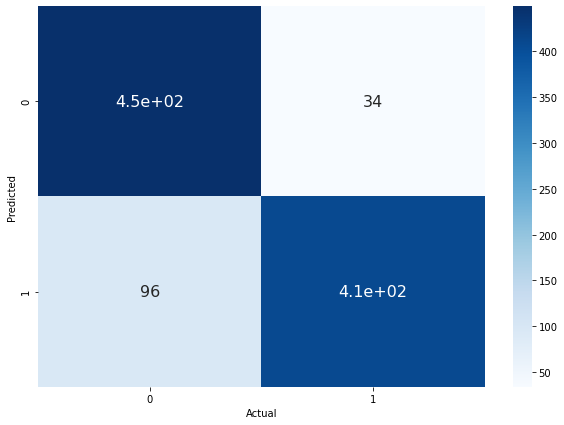

In [35]:
import seaborn as sns
cm_cnn_bst = confusion_matrix(Y_true_cnn_bst, y_pred_cnn_bst)
print('Confusion matrix:\n',cm_cnn_bst)

print(classification_report(Y_true_cnn_bst, y_pred_cnn_bst))

print('Plot of Confusion Matrix')
df_cm_cnn_bst = pd.DataFrame(cm_cnn_bst, columns=np.unique(Y_true_cnn_bst), index = np.unique(Y_true_cnn_bst))
df_cm_cnn_bst.index.name = 'Predicted'
df_cm_cnn_bst.columns.name = 'Actual'
plt.figure(figsize = (10,7))
#sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm_cnn_bst, cmap="Blues", annot=True, annot_kws={"size": 16})# font size

In [36]:
from sklearn.metrics import roc_auc_score
print('ROC_AUC score:',roc_auc_score(Y_true_cnn_bst, y_pred_cnn_bst))
df_cm_cnn_bst

ROC_AUC score: 0.8697538076789045


Actual,0,1
Predicted,,
0,449,34
1,96,409


In [37]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[449  34]
 [ 96 409]]


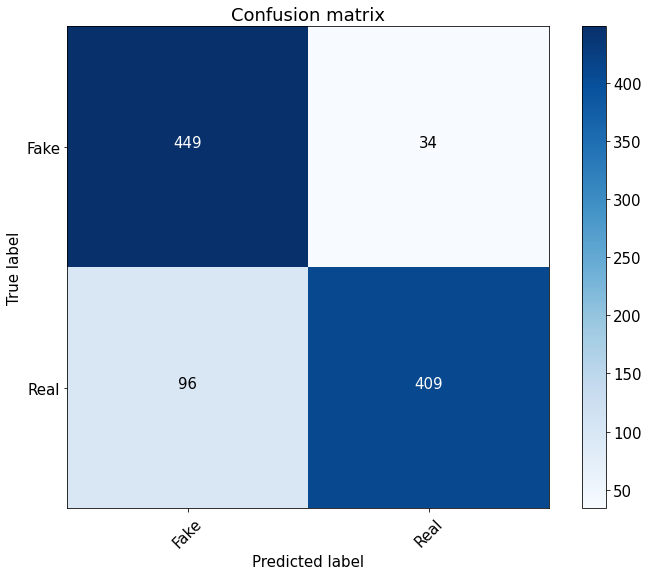

In [39]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_svm = confusion_matrix(Y_true_cnn_bst, y_pred_cnn_bst)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_svm, classes=['Fake', 'Real'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_cnn_bst.png")
plt.show()